## Examples of GeoPandas and KeplerGL using London crime data

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import necessary modules
import geopandas as gpd
import fiona
import dask 
import vaex
from keplergl import KeplerGl
import requests
import logging
from requests.exceptions import HTTPError, ConnectionError
import sys
import mapclassify
#import geoplot
import rtree
# wget http://aprsworld.net/gisdata/world/world.zip
#fp = "L2_data/DAMSELFISH_distributions.shp"
# Read file using gpd.read_file()
#data = gpd.read_file(fp)

# this will remove the root logger and avoid duplicate logs in notebook
for handler in logging.getLogger().handlers:
    logging.getLogger().removeHandler(handler)
    
logger = logging.getLogger()
handle = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handle.setFormatter(formatter)
logger.addHandler(handle)
logger.setLevel(logging.INFO)

/Users/rk1103/.local/share/virtualenvs/geospatial-cDyY7PCI/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Loading london shape files and switching to EPSG coordinate system (lat/lon)

In [3]:

london_map = gpd.read_file('../data/ESRI/London_Borough_Excluding_MHW.shp')
london_map = london_map.to_crs(epsg=4326) 
 # for mercator projection we could use epsg=3395
# for this map
london_map.crs

2021-05-15 21:14:32,736 - fiona.ogrext - INFO - Failed to auto identify EPSG: 7


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
# get rid of the columns we do not need

london_map = london_map.loc[:, ['NAME', 'GSS_CODE', 'geometry']].rename({'NAME': 'borough'})
london_map.head(10)



,NAME,GSS_CODE,geometry
0,Kingston upon Thames,E09000021,POLYGON ((-0.3306790218922088 51.3290110042254...
1,Croydon,E09000008,POLYGON ((-0.0640211986132681 51.3186376532417...
2,Bromley,E09000006,POLYGON ((0.0121309794638101 51.29959905294953...
3,Hounslow,E09000018,POLYGON ((-0.2445623530855486 51.4887021698921...
4,Ealing,E09000009,POLYGON ((-0.4118326481684373 51.5340838562922...
5,Havering,E09000016,POLYGON ((0.1586928734973455 51.51218596234164...
6,Hillingdon,E09000017,POLYGON ((-0.4040719311011609 51.6131804167914...
7,Harrow,E09000015,POLYGON ((-0.4040719311011609 51.6131804167914...
8,Brent,E09000005,POLYGON ((-0.1965687047673788 51.5276540041398...
9,Barnet,E09000003,POLYGON ((-0.1998963625553726 51.6701668512060...


### Now lets call the data.police API and fetch some crime data for London

In [6]:
import os
from functools import partial

url_base="https://data.police.uk/api/"
ignored_outcomes = ['A no further action disposal', False, '']

def get_request(url):
    response=requests.get(url, timeout=30)
    try:
    # If the response was successful, no Exception will be raised
        response.raise_for_status()
    except HTTPError as http_err:
        logger.exception(f'HTTP error occurred: {http_err}')
    except Exception as err:
        pass
        logger.exception(f'Other error occurred: {err}')
    else:
        logger.info(f'HTTP request for {url} was successful!')

    response.encoding = 'utf-8'
    
    return response.json()

def get_neighbourhoods(get_request, police_id):
    
    url = os.path.join(url_base, f"{police_id}/neighbourhoods")

    return get_request(url)

def get_stop_search_by_force(get_request, police_id, date=None):
    """
    Retrieve stop and search data for a given police force. if date is not provided,
    returns all stop and search data which have lead to outcomes like arrest, court summons
    for latest month(s).Also removes any data with no location info
    """
    
    new_list = []
    if date is None:
        url = os.path.join(url_base, f"stops-force?force={police_id}")
    else:
        url = os.path.join(url_base, f"stops-force?force={police_id}&date={date}")
    response = get_request(url)
    for json in response:
        if (json.get('outcome') not in ignored_outcomes) and (json.get('location') is not None):
            new_list.append(json)
        
    logger.info(f"Successfully fetched data from month: {date}")
    return new_list


def available_data_dates(get_request, force_id, months=3):
    """
    returns availble dates - data available for given force id
    and recent number of available months
    """
    
    url = os.path.join(url_base, "crimes-street-dates")
    
    response = get_request(url)
    
    available_dates = []
    
    for json in response:
        if len(available_dates) == months:
            break
        else:
            if 'metropolitan' in json.get('stop-and-search'):
                available_dates.append(json.get('date'))
                
                
    logger.info(f'The available dates are {",".join(available_dates)}')

    return None
    
    
def get_police_id(get_request, force_name):
    """
    Get police id and police force names in json
    """
    url = os.path.join(url_base, "forces")
    response = get_request(url)
    for json in response:
        if json.get('name') == force_name:
            police_id = json.get('id')
            break
            
    logger.info(f"Police id for {force_name}:- '{police_id}'")
    
    return police_id

In [7]:
#force_name='Avon and Somerset Constabulary'
force_name='Metropolitan Police Service'
police_id = get_police_id(get_request, force_name)

#get_stop_search_by_force(get_request, police_id,date='2019-03')
available_data_dates(get_request, police_id)
neighbourhoods = get_neighbourhoods(get_request, police_id)
    
crime_london_json = get_stop_search_by_force(get_request, police_id, date='2018-05')

2021-05-15 21:15:51,313 - root - INFO - HTTP request for https://data.police.uk/api/forces was successful!
2021-05-15 21:15:51,315 - root - INFO - Police id for Metropolitan Police Service:- 'metropolitan'
2021-05-15 21:15:51,914 - root - INFO - HTTP request for https://data.police.uk/api/crimes-street-dates was successful!
2021-05-15 21:15:51,916 - root - INFO - The available dates are 2021-03,2021-02,2021-01
2021-05-15 21:15:52,730 - root - INFO - HTTP request for https://data.police.uk/api/metropolitan/neighbourhoods was successful!
2021-05-15 21:16:13,660 - root - INFO - HTTP request for https://data.police.uk/api/stops-force?force=metropolitan&date=2018-05 was successful!
2021-05-15 21:16:13,756 - root - INFO - Successfully fetched data from month: 2018-05


In [8]:
print(f'We have {len(crime_london_json)} street search arrests with location information')


We have 3210 street search arrests with location information


### Convert to Geopandas dataframe after reassinging types and removing some columns

In [9]:
data = pd.DataFrame(crime_london_json)
data['latitude'] = data['location'].map(lambda x: np.float(x['latitude']))
data['longitude'] = data['location'].map(lambda x: np.float(x['longitude']))
data['datetime'] = data['datetime'].astype('datetime64[ns]')
data['gender'] = data['gender'].astype ('category')
data['outcome'] = data['outcome'].astype ('category')
data = data[['datetime', 'latitude', 'longitude','outcome', 'gender', 'object_of_search']]

geo_ds = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
geo_ds.head()

<ipython-input-9-9a5bd644c1f1>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data['latitude'] = data['location'].map(lambda x: np.float(x['latitude']))
<ipython-input-9-9a5bd644c1f1>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data['longitude'] = data['location'].map(lambda x: np.float(x['longitude']))


,datetime,latitude,longitude,outcome,gender,object_of_search,geometry
0,2018-05-02 07:00:00,51.513873,-0.178017,Arrest,Male,Stolen goods,POINT (-0.17802 51.51387)
1,2018-05-04 09:10:00,51.471396,-0.455787,Community resolution,Male,Controlled drugs,POINT (-0.45579 51.47140)
2,2018-05-09 01:35:00,51.475074,-0.493087,Community resolution,Male,Stolen goods,POINT (-0.49309 51.47507)
3,2018-05-10 08:05:00,51.469708,-0.451842,Community resolution,Female,Stolen goods,POINT (-0.45184 51.46971)
4,2018-05-13 17:10:00,51.500632,-0.420192,Community resolution,Male,Controlled drugs,POINT (-0.42019 51.50063)


<AxesSubplot:>

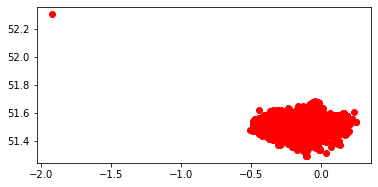

In [10]:
geo_ds.plot(color='red')

<AxesSubplot:>

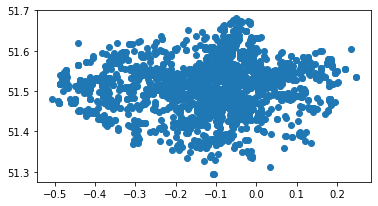

In [11]:
# there is some random point in wrong latitude/long in top left corner outside Londo - lets get rid of it

geo_ds = geo_ds.loc[geo_ds['longitude'] > -1, :]

geo_ds.plot()

In [28]:
london_map = gpd.read_file('../data/london_basemap.geojson')

### Overlay crime events on basemap 

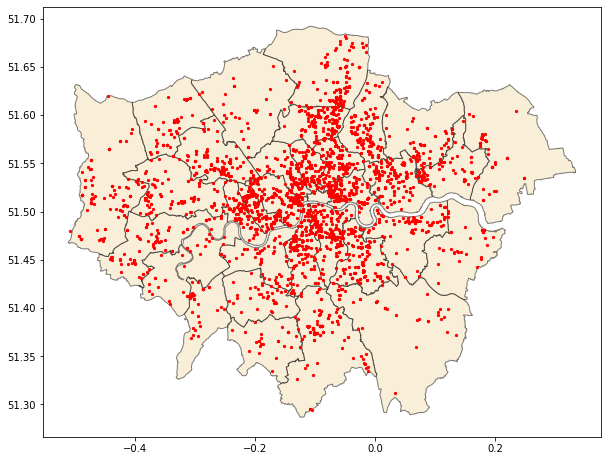

In [33]:
ax = london_map.plot(figsize=(10, 10), alpha=0.5, color="wheat", edgecolor="black")  
new_ax = geo_ds.plot(ax=ax, marker="o", color="red", markersize=5)

### Now create a cholorpeth map so we can visualise number of crimes via colour scheme and group by other columns

In [29]:
merged_df = gpd.sjoin(london_map, geo_ds, how="inner", op='intersects')
merged_df['outcome'] = merged_df['outcome'].cat.rename_categories({'Caution (simple or conditional)':'Caution', 
                                                              'Khat or Cannabis warning':'Drugs warning',
                                                              'Penalty Notice for Disorder':'Penalty Notice for Disorder',
                                                              'Summons / charged by post': 'Summons'})


In [36]:

total_crimes_borough = merged_df.groupby(['NAME'])['outcome'].count().reset_index()

df_chloro = merged_df[['NAME', 'geometry']].merge(total_crimes_borough, how='inner', on='NAME').rename({'outcome':'crimes'}, axis='columns')
df_chloro = df_chloro.drop_duplicates().reset_index(drop=True)
df_chloro.head()

,NAME,geometry,crimes
0,Kingston upon Thames,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",33
1,Croydon,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861...",99
2,Bromley,"POLYGON ((0.01213 51.29960, 0.01196 51.29980, ...",45
3,Hounslow,"POLYGON ((-0.24456 51.48870, -0.24468 51.48868...",78
4,Ealing,"POLYGON ((-0.41183 51.53408, -0.41188 51.53412...",90


/Users/rk1103/.local/share/virtualenvs/geospatial-cDyY7PCI/lib/python3.8/site-packages/mapclassify/classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/rk1103/.local/share/virtualenvs/geospatial-cDyY7PCI/lib/python3.8/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 96
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

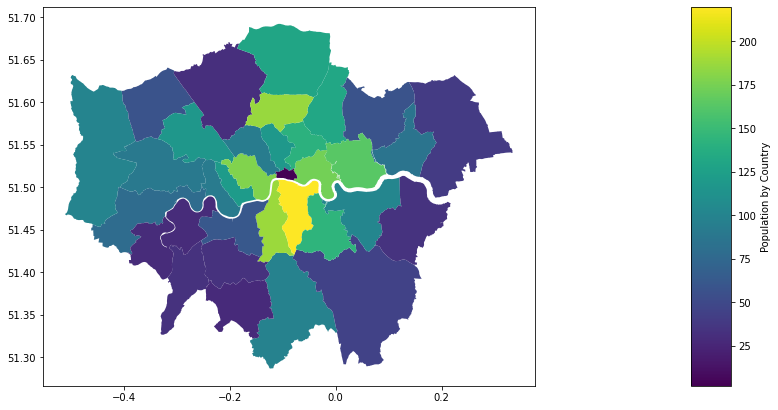

In [60]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
scheme = mapclassify.Quantiles(df_chloro['crimes'], k=100)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
df_chloro.plot(column='crimes',ax=ax,legend=True,legend_kwds={"label": "Population by Country"},cax=cax)


#geoplot.choropleth(df_chloro, hue=df_chloro['crimes'], scheme=scheme, cmap='Greens', figsize=(12, 12))

### Kepler GL

In [4]:
# Load an empty map


m = KeplerGl()
m.add_data(london_map)
display(m)


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

In [13]:
london_map

,NAME,GSS_CODE,geometry
0,Kingston upon Thames,E09000021,POLYGON ((-0.3306790218922088 51.3290110042254...
1,Croydon,E09000008,POLYGON ((-0.0640211986132681 51.3186376532417...
2,Bromley,E09000006,POLYGON ((0.0121309794638101 51.29959905294953...
3,Hounslow,E09000018,POLYGON ((-0.2445623530855486 51.4887021698921...
4,Ealing,E09000009,POLYGON ((-0.4118326481684373 51.5340838562922...
5,Havering,E09000016,POLYGON ((0.1586928734973455 51.51218596234164...
6,Hillingdon,E09000017,POLYGON ((-0.4040719311011609 51.6131804167914...
7,Harrow,E09000015,POLYGON ((-0.4040719311011609 51.6131804167914...
8,Brent,E09000005,POLYGON ((-0.1965687047673788 51.5276540041398...
9,Barnet,E09000003,POLYGON ((-0.1998963625553726 51.6701668512060...
